## Æther: Pipeline


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to(device)

In [11]:
def loadDataset(labels_path, base_dir):
    """Load dataset more efficiently by reading unique files only once"""
    labels_path = Path(labels_path)
    base_dir = Path(base_dir)

    # Validate paths
    if not labels_path.exists() or not labels_path.is_file():
        raise FileNotFoundError(f"Labels file not found: {labels_path}")
    if not base_dir.exists() or not base_dir.is_dir():
        raise FileNotFoundError(f"Base directory not found: {base_dir}")

    # Load labels
    df = pd.read_csv(labels_path)

    # Get unique file IDs to load only once
    unique_ids = pd.concat([df["id1"], df["id2"]]).unique()

    # Load files in one pass
    files = {}
    for file_id in tqdm(unique_ids, desc="Loading files"):
        path = base_dir / f"{file_id}.java"
        if path.exists():
            try:
                files[file_id] = path.read_text(encoding="utf-8")
            except UnicodeDecodeError:
                files[file_id] = path.read_text(encoding="latin-1")
        else:
            raise FileNotFoundError(f"File not found: {path}")

    # Map files to dataframe
    df["file1"] = df["id1"].map(files)
    df["file2"] = df["id2"].map(files)
    df["plagio"] = df["plagio"].astype(int)

    return df

In [12]:
def encode_batch(texts, batch_size=16):
    """Custom encoding function that minimizes GPU transfers"""
    all_embeddings = []

    # Process in batches to avoid OOM issues
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding batches"):
        batch_texts = texts[i : i + batch_size]

        # Tokenize on CPU
        inputs = tokenizer(
            batch_texts, padding="max_length", truncation=True, return_tensors="pt"
        )

        # Transfer to GPU only once per batch
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings (no gradient needed)
        with torch.no_grad():
            outputs = model(**inputs)

        # Use mean pooling of last hidden state as embedding
        # Taking mean across token dimension (dim=1)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)

        # Move back to CPU and convert to numpy only once per batch
        all_embeddings.append(embeddings.cpu().numpy())

    # Stack all batch results
    return np.vstack(all_embeddings) if all_embeddings else np.array([])

def encode(text):
    """Encode a single text input"""
    inputs = tokenizer(
        text, padding="max_length", truncation=True, return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling of last hidden state as embedding
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)[0]
    return embeddings.cpu().numpy()


In [ ]:
def process_dataset(dataset):
    """Process dataset by encoding unique files only once"""
    # Extract all unique files to encode
    all_files = []
    file_to_idx = {}

    # Create list of unique files
    unique_files = set()
    for file1, file2 in zip(dataset["file1"], dataset["file2"]):
        unique_files.add(file1)
        unique_files.add(file2)

    # Convert to list and create mapping
    all_files = list(unique_files)
    file_to_idx = {file: idx for idx, file in enumerate(all_files)}

    print(f"Encoding {len(all_files)} unique files...")

    # Encode all unique files at once
    all_encodings = encode_batch(all_files, 128)

    # Create a dict mapping from file content to encoding
    file_to_encoding = {file: all_encodings[idx] for file, idx in file_to_idx.items()}

    # Create a map function to add encodings
    def add_encodings(example):
        return {
            "encodedFile1": file_to_encoding[example["file1"]],
            "encodedFile2": file_to_encoding[example["file2"]],
        }

    # Use dataset.map() to add the encodings columns
    return dataset.map(add_encodings)

In [14]:
def compute_cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors"""
    # Normalize vectors
    vec1_norm = vec1 / np.linalg.norm(vec1)
    vec2_norm = vec2 / np.linalg.norm(vec2)
    # Calculate similarity
    return np.dot(vec1_norm, vec2_norm)


def add_similarity_scores(dataset):
    """Add cosine similarity scores to dataset"""

    def add_similarity(example):
        sim = compute_cosine_similarity(
            example["encodedFile1"], example["encodedFile2"]
        )
        return {"similarity": sim}

    # Use dataset.map() to add the similarity column
    return dataset.map(add_similarity)

In [15]:
def find_optimal_threshold(y_true, y_scores):
    """
    Find the optimal threshold for binary classification using ROC curve.
    """
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def evaluate_model(df):    
    threshold = find_optimal_threshold(df["plagio"].values, df["similarity"].values)
    print(f"Optimal threshold: {threshold:.2f}")
    df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

    # Calculate the accuracy
    accuracy = (df["predicted"] == df["plagio"]).mean()
    print(f"Accuracy: {accuracy:.2f}")
    # Calculate the confusion matrix
    cm = confusion_matrix(df["plagio"], df["predicted"])
    # Calculate the classification report
    report = classification_report(df["plagio"], df["predicted"])
    print(report)
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Plagiarized", "Plagiarized"])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()
    # Plot the distribution of the similarity scores
    plt.figure(figsize=(10, 7))
    plt.hist(df["similarity"], bins=50, alpha=0.7, color="blue", label="Similarity Scores")
    plt.axvline(threshold, color="red", linestyle="--")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.show()
    # Plot the distribution of the similarity scores for plagiarized and not plagiarized

In [16]:
import time

# Define paths
LABELS_PATH = "../../labels/conplag_labels.csv"
BASE_DIR = "../../datasets/conplag_preprocesed"
# LABELS_PATH = "research/labels/conplag_labels.csv"
# BASE_DIR = "research/datasets/conplag_preprocesed"

# Load the dataset
print("Loading dataset...")
df = loadDataset(LABELS_PATH, BASE_DIR)
dataset = Dataset.from_pandas(df)

# Process dataset (encode files)
print("Processing dataset...")
encoded_dataset = process_dataset(dataset)

# Compute similarity scores
print("Computing similarity scores...")
final_dataset = add_similarity_scores(encoded_dataset)

df = final_dataset.to_pandas()

print("Done!")

Loading dataset...


Loading files: 100%|██████████| 975/975 [00:00<00:00, 28404.46it/s]


Processing dataset...
Encoding 946 unique files...


Map: 100%|██████████| 911/911 [00:00<00:00, 11720.28 examples/s]


Computing similarity scores...


Map: 100%|██████████| 911/911 [00:00<00:00, 1611.53 examples/s]

Done!


Optimal threshold: 0.93
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       660
           1       0.78      0.45      0.57       251

    accuracy                           0.81       911
   macro avg       0.80      0.70      0.72       911
weighted avg       0.81      0.81      0.79       911



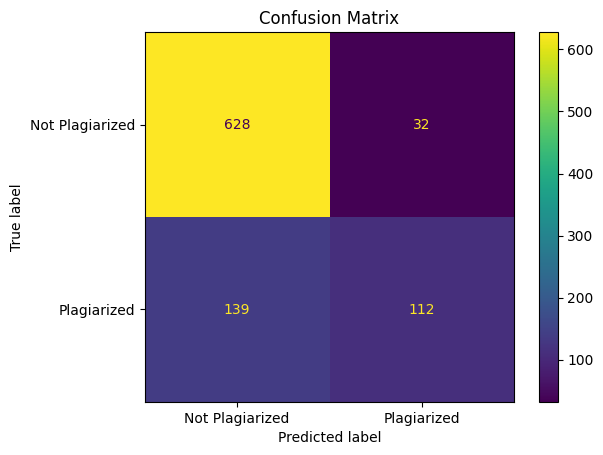

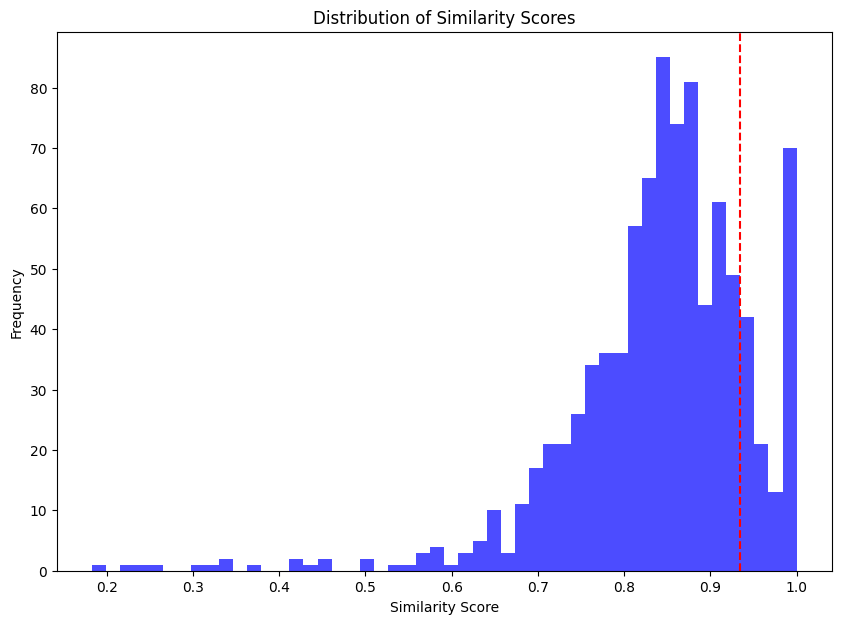

In [17]:
evaluate_model(df)